In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('anime-generative-modeling-project')
jovian.set_colab_id('1FG_46ZtOo_0sEvFue_2Qp2NGj2Dzw_9J')

# Anime generative modeling course project
A project on anime face for fun.

In [2]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade -q
project = 'Anime-generative modeling-project'

In [3]:
import opendatasets as od
import matplotlib.pyplot as plt
import torch
import os
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from IPython.display import Image
import cv2
import shutil

# Downloading dataset

In [4]:
dataset = 'https://www.kaggle.com/soumikrakshit/anime-faces'
od.download(dataset)

Skipping, found downloaded files in "./anime-faces" (use force=True to force download)


# **Dataset**


1.   It is a image dataset. it contains anime faces.
2.   It is a generative modeling problem in which we generate fake images by model.



# Clean data and Exploratory Analysis

In [5]:
data2 = './anime-faces/data/data'
if os.path.isdir(data2):
    shutil.rmtree(data2)
    print('Required directory removed...')

In [6]:
images = './anime-faces'
os.listdir(images)

['data']

In [7]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(images, transform=T.Compose([
                                                   T.Resize(image_size),
                                                   T.CenterCrop(image_size),
                                                   T.ToTensor(),
                                                   T.Normalize(*stats)]))

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
def denorm(img_tensor):
  return img_tensor * stats[1][0] + stats[0][0]
  
def show_image(image):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.imshow(make_grid(denorm(image.detach()), nrow=8).permute(1, 2, 0))

def show_batch(dl):
  for image, _ in dl:
    show_image(image)
    break

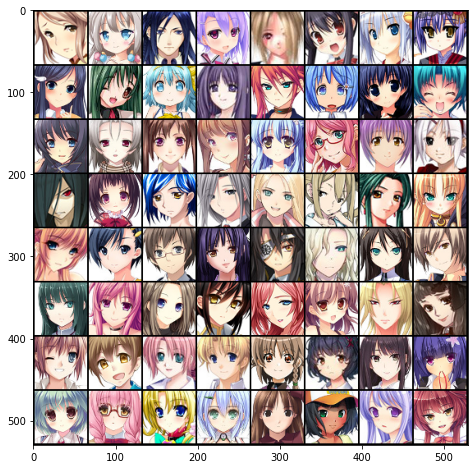

In [11]:
show_batch(train_dl)

# Modeling

Define a model (network architecture)

Train the model

Pick some hyperparameters

Evaluate on the test dataset

Save the model weights

Record the metrics

Try different hyperparameters & regularization

Example of generated images

Conclusions - summarize your learning & identify opportunities for future work

Publish and submit your Jupyter notebook

# Setting Device for Data

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

# Model

1.   Discriminator
2.   Generator



# Discriminator

In [15]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace=True),
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [16]:
discriminator = to_device(discriminator, device)

## Generator

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),

    nn.Tanh()
)

In [19]:
generator = to_device(generator, device)

In [20]:
jovian.commit(project=project)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aishpal6/anime-generative-modeling-project


'https://jovian.ai/aishpal6/anime-generative-modeling-project'

# Train the model

1.   Training Discriminator
2.   Training Generator



# Training Discriminator

In [21]:
def to_discriminator(images, real=True):
  preds = discriminator(images)
  if real:
    targets = torch.ones(images.size(0), 1, device=device) 
  else:
    targets = torch.zeros(images.size(0), 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)
  score = torch.mean(preds)
  return loss, score.item()

def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  real_loss, real_score = to_discriminator(real_images)
  
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)
  
  fake_loss, fake_score = to_discriminator(fake_images, real=False)

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score

# Training Generator

In [22]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)
  
  loss.backward()
  opt_g.step()

  return loss.item()

### Defining saving-function before starting training


In [23]:
new_dir = 'Generated images'
os.makedirs(new_dir, exist_ok=True)

In [24]:
def save_samples(index, latent, show=False):
  fake_images = generator(latent)
  fake_name = 'generated-images-set-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(new_dir, fake_name), nrow=8)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8));
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0));

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

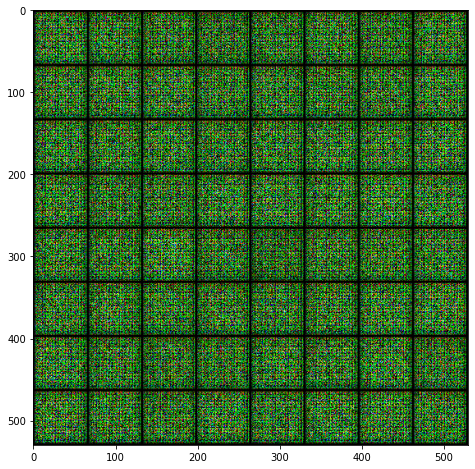

In [26]:
save_samples(0, fixed_latent, show=True)

# Training starts

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
jovian.commit(project=project)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aishpal6/anime-generative-modeling-project


'https://jovian.ai/aishpal6/anime-generative-modeling-project'

# Hyperparameters

In [29]:
lr = 2e-4
epochs = 10

# Evaluate on the test dataset

In [30]:
history = fit(epochs, lr)

  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 9.1323, loss_d: 1.4408, real_score: 0.8761, fake_score: 0.6942


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 5.5855, loss_d: 0.6579, real_score: 0.8784, fake_score: 0.3834


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 8.1581, loss_d: 0.6094, real_score: 0.9922, fake_score: 0.4035


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.5468, loss_d: 0.2561, real_score: 0.8711, fake_score: 0.0607


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 4.9124, loss_d: 0.3024, real_score: 0.9184, fake_score: 0.1725


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 2.1171, loss_d: 0.5237, real_score: 0.6885, fake_score: 0.0223


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.7536, loss_d: 0.1968, real_score: 0.8485, fake_score: 0.0035


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.0586, loss_d: 0.1986, real_score: 0.9027, fake_score: 0.0742


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 9.4181, loss_d: 0.4767, real_score: 0.9800, fake_score: 0.3332


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.8344, loss_d: 0.1978, real_score: 0.9496, fake_score: 0.1222


# Save the model weights

In [31]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [32]:
torch.save(generator.state_dict(), 'G_pth')
torch.save(discriminator.state_dict(), 'D_pth')

In [33]:
jovian.commit(project=project)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/aishpal6/anime-generative-modeling-project


'https://jovian.ai/aishpal6/anime-generative-modeling-project'

# Record the metrics

In [34]:
jovian.log_metrics(loss_d = history[0][-1],
                   loss_g = history[1][-1],
                   real_score = str(history[2][-1]),
                   fake_score = str(history[3][-1])
                   )

[jovian] Metrics logged.


# Try different hyperparameters & regularization

In [35]:
start_idx = epochs+1
lr = 1e-6
epochs = 10

In [36]:
history2 = fit(epochs, lr, start_idx)

  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 3.3870, loss_d: 0.1917, real_score: 0.8901, fake_score: 0.0562


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 4.1233, loss_d: 0.0772, real_score: 0.9702, fake_score: 0.0432


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 3.8499, loss_d: 0.0630, real_score: 0.9720, fake_score: 0.0319


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 4.6357, loss_d: 0.0413, real_score: 0.9774, fake_score: 0.0177


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 4.1789, loss_d: 0.0453, real_score: 0.9764, fake_score: 0.0198


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.7559, loss_d: 0.0331, real_score: 0.9803, fake_score: 0.0125


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.6148, loss_d: 0.0440, real_score: 0.9711, fake_score: 0.0133


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 5.1371, loss_d: 0.0347, real_score: 0.9813, fake_score: 0.0137


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.5227, loss_d: 0.0443, real_score: 0.9723, fake_score: 0.0153


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.8286, loss_d: 0.0226, real_score: 0.9865, fake_score: 0.0082


# Example of generated images

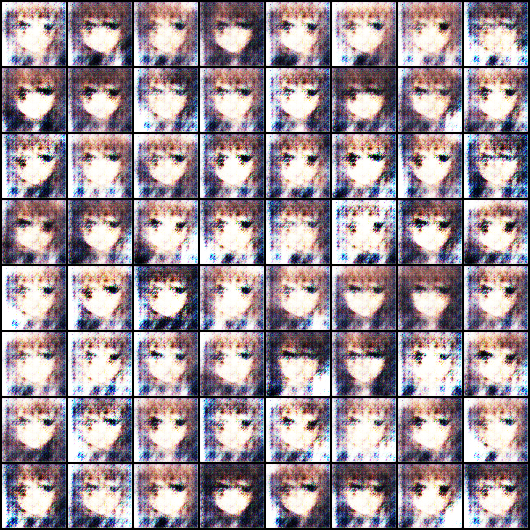

In [37]:
Image('./Generated images/generated-images-set-{0:0=4d}.png'.format(1))

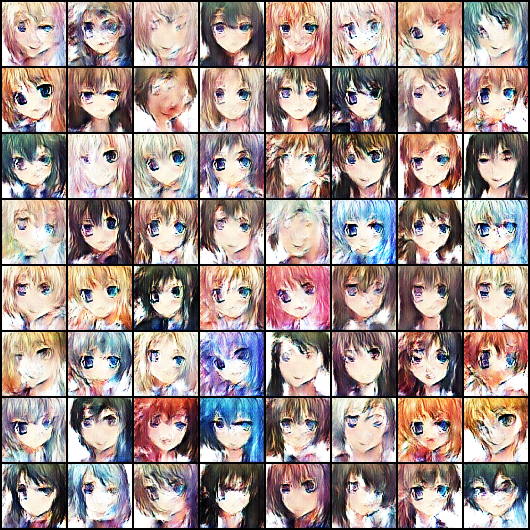

In [38]:
Image('./Generated images/generated-images-set-{0:0=4d}.png'.format(10))

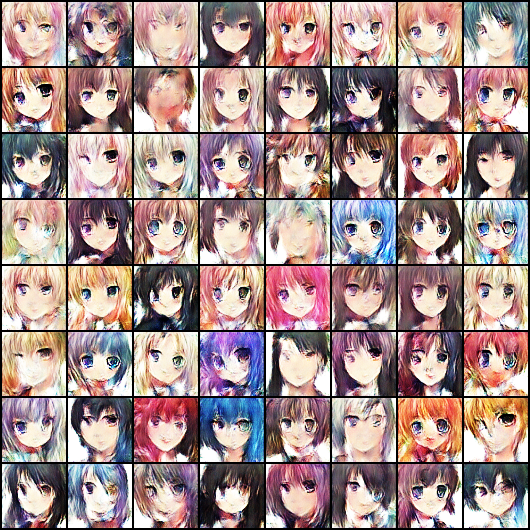

In [39]:
Image('./Generated images/generated-images-set-{0:0=4d}.png'.format(20))

Making video by Generated images

In [42]:
Vname = 'Generated Images.avi'
images = [os.path.join(new_dir, image) for image in os.listdir(new_dir) if 'generated' in image]
images.sort()
out = cv2.VideoWriter(Vname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(name)) for name in images]
out.release()

# Conclusions
It was a awesome journey. I taught many greats things and want to learn more about it.

I will use what I have learn, on different datasets. It was exciting and I am looking forward to it.


In [43]:
!pip install jovian --upgrade -q
import jovian
jovian.commit(project=project)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/aishpal6/anime-generative-modeling-project


'https://jovian.ai/aishpal6/anime-generative-modeling-project'